In [1]:
from langgraph.graph import StateGraph,START,END
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from typing import TypedDict,Annotated
from pydantic import BaseModel,Field
import operator

In [2]:
load_dotenv()

True

In [3]:
model = ChatOpenAI(model = 'gpt-4o-mini')

In [4]:
class EvaluationSchema(BaseModel):
    
    feedback : str = Field(description= "Detailed Feedback for the Essay")
    score : int = Field(description= "Score Out of 10",ge=0,le=10)

In [23]:
structured_model = model.with_structured_output(EvaluationSchema)

In [24]:
essay = """
The Role of Artificial Intelligence in India

Artificial Intelligence (AI) has emerged as one of the most transformative technologies of the 21st century. In India, a country with a vast population and diverse challenges, AI is playing a crucial role in reshaping industries, improving governance, and driving economic growth. From healthcare to agriculture and education to public services, AI is opening new possibilities for innovation and development.

In governance, AI is helping the government provide faster and more efficient services to citizens. Chatbots and automated platforms are being used to handle public queries and grievances. AI-based systems are also being introduced for traffic management, crime prediction, and disaster response, making cities smarter and safer. Through initiatives like Digital India and the National AI Mission, the government is encouraging the adoption of AI in both public and private sectors.

Healthcare in India is another field where AI is showing a strong impact. AI-powered tools assist doctors in diagnosing diseases more accurately through medical imaging and predictive analytics. Rural areas, which often suffer from a shortage of doctors, are now benefiting from AI-driven telemedicine and mobile health solutions. The COVID-19 pandemic highlighted how AI could support contact tracing, vaccine research, and patient monitoring at a large scale.

Agriculture, the backbone of India’s economy, is also being modernized through AI. Farmers are using AI tools for crop monitoring, soil analysis, pest detection, and weather forecasting. These technologies allow them to make better decisions, improve crop yield, and reduce losses. AI-based applications are helping small farmers in rural India adopt smart farming practices that were earlier out of reach.

The education sector is equally benefiting from AI. EdTech platforms use AI to create personalized learning experiences for students, helping them learn at their own pace. Automated grading systems save time for teachers, while AI-powered translation tools make learning materials available in regional languages. This is helping bridge the gap between rural and urban education and making quality learning more accessible.

Economically, AI is strengthening industries such as banking, finance, manufacturing, and retail. Banks are using AI for fraud detection and customer support, while industries are adopting AI for automation, predictive maintenance, and data analysis. The startup ecosystem in India is also increasingly focused on AI-based solutions, contributing to job creation and innovation.

However, the growth of AI in India also comes with challenges. Issues of data privacy, security, and ethical use of AI remain important concerns. There is also a growing need to train the workforce in AI and related technologies so that India can fully harness its potential. Bridging the digital divide between rural and urban areas is another critical task for inclusive growth.

In conclusion, the role of AI in India is both promising and transformative. With government support, a young talent pool, and a growing digital infrastructure, India has the potential to become a global leader in AI. If developed responsibly and inclusively, AI can not only strengthen India’s economy but also improve the quality of life for millions of people across the country."""

In [25]:
prompt = f"Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10 \n{essay}"
structured_model.invoke(prompt).score
structured_model.invoke(prompt).feedback

'The essay presents a well-structured analysis of the role of Artificial Intelligence (AI) in India, effectively covering its impact across various sectors such as governance, healthcare, agriculture, education, and the economy. The language quality is generally high, demonstrating clarity and coherence throughout. However, the essay could benefit from a more varied vocabulary and deeper exploration of challenges. While it mentions data privacy and ethical issues, these topics could be elaborated further for a more balanced perspective. The conclusion summarizes the main points well but could also include specific examples or initiatives to strengthen its arguments. Overall, the essay is informative and relevant, but minor improvements in depth and vocabulary could enhance its quality.'

In [26]:
class UPSCState(TypedDict):
    essay: str
    language_feedback: str
    analysis_feedback: str
    clarity_feedback : str
    overall_feedback : str
    individual_scores : Annotated[list[int],operator.add]
    avg_score: float

In [27]:
def evaluate_language(state:UPSCState):
    prompt = f"Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10 \n {state['essay']}"
    output = structured_model.invoke(prompt)
    
    return {'language_feedback':output.feedback,'individual_scores':[output.score]}


In [28]:
def  evaluate_analysis(state:UPSCState):
    
    prompt= f"Evaluate the depth of analysis of the following essay and provide a feedback and assign a score out of 1 \n {state['essay']}"
    output= structured_model.invoke(prompt)
    
    return {'analysis_feedback': output.feedback,'individual_scores':[output.score]}


In [34]:
def final_evaluation(state:UPSCState):
    
    # summary feedback
    prompt = f"Based on the following feedback create a summarized feedback \n language feedback - {state['language_feedback']} \n depth of analysis feedback - {state['analysis_feedback']} \n clarity of thought feedback - {state['clarity_feedback']}"
    overall_feedback = model.invoke(prompt).content
    
    # avg_score 
    avg_score = sum(state['individual_scores'])/len(state['individual_scores'])
    
    return{'overall_feedback': overall_feedback,'avg_score':avg_score}

In [35]:
def evaluate_thought(state : UPSCState):
    
    prompt = f"Evaluate the clarity of thought of the following essay and provide a feedback and assign a score out of 10 \n {state['essay']}"
    output = structured_model.invoke(prompt) 
    
    return {'clarity_feedback': output.feedback,'individual_scores':[output.score]}


In [36]:
graph = StateGraph(UPSCState)
graph.add_node('evaluate_language',evaluate_language)
graph.add_node('evaluate_analysis',evaluate_analysis)
graph.add_node('evaluate_thought',evaluate_thought)
graph.add_node('final_evaluation',final_evaluation)

# edges
graph.add_edge(START,'evaluate_language')
graph.add_edge(START,'evaluate_analysis')
graph.add_edge(START,'evaluate_thought')

graph.add_edge('evaluate_language','final_evaluation')
graph.add_edge('evaluate_analysis','final_evaluation')
graph.add_edge('evaluate_thought','final_evaluation')

graph.add_edge('final_evaluation',END)

workflow = graph.compile()

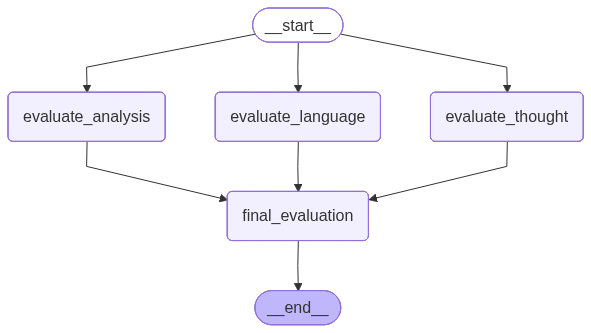

In [37]:
workflow

In [38]:
initial_state = {
    'essay' : essay
}

workflow.invoke(initial_state)

{'essay': '\nThe Role of Artificial Intelligence in India\n\nArtificial Intelligence (AI) has emerged as one of the most transformative technologies of the 21st century. In India, a country with a vast population and diverse challenges, AI is playing a crucial role in reshaping industries, improving governance, and driving economic growth. From healthcare to agriculture and education to public services, AI is opening new possibilities for innovation and development.\n\nIn governance, AI is helping the government provide faster and more efficient services to citizens. Chatbots and automated platforms are being used to handle public queries and grievances. AI-based systems are also being introduced for traffic management, crime prediction, and disaster response, making cities smarter and safer. Through initiatives like Digital India and the National AI Mission, the government is encouraging the adoption of AI in both public and private sectors.\n\nHealthcare in India is another field whe

In [39]:
essay2 = """
Artificial Intelligence is changing India in many ways and its role is getting bigger every day it helps people in citys and villages, but sometimes it also causes problems. In government jobs AI is used for quick replies and to reduce work load, many websites have chatbots which answers citizen questions fast but they are not always correct. In health care AI helps doctors to look at x rays and find problems earlier which is good for patients, and some apps try to give medical advice to people in remote areas though this is not the same as a real doctor so it can be risky. Farmers also get help from AI, there are apps that tell when to water or spray pesticide and they can increase crop yield, however many farmers cannot use smartphones or they dont trust the apps so adoption is slow.

In schools AI is used to create lessons that adapt to each student which makes learning easier, but some teachers feel replaced and worry about job security. Business and banks use AI for fraud detection and customer service and this saves money and time, while industries use robots and machines for faster production. Yet these changes sometimes lead to job losses and people need to learn new skills quickly or they will be left behind. Privacy is another issue because AI systems often collect lots of personal data and there are not enough strong laws to protect everyone. Also AI systems can make biased decisions because they are trained on old data which contains human mistakes.

Overall AI can bring many benefits to India and help improve life for millions, but it is not perfect and cant solve every problem by itself. If government, companies and people work together, and teach workers new skills, AI will be more useful and safer, but we must be careful and check systems often so things dont go wrong."""

In [40]:
initial_state = {
    'essay' : essay2
}

workflow.invoke(initial_state)

{'essay': '\nArtificial Intelligence is changing India in many ways and its role is getting bigger every day it helps people in citys and villages, but sometimes it also causes problems. In government jobs AI is used for quick replies and to reduce work load, many websites have chatbots which answers citizen questions fast but they are not always correct. In health care AI helps doctors to look at x rays and find problems earlier which is good for patients, and some apps try to give medical advice to people in remote areas though this is not the same as a real doctor so it can be risky. Farmers also get help from AI, there are apps that tell when to water or spray pesticide and they can increase crop yield, however many farmers cannot use smartphones or they dont trust the apps so adoption is slow.\n\nIn schools AI is used to create lessons that adapt to each student which makes learning easier, but some teachers feel replaced and worry about job security. Business and banks use AI for

In [41]:
essay3 = """
The Role of Artificial Inteligence in India

Artificial Inteligence (AI) is very popular now a days in India. Many pepole say it will change the future completly and make life very easy, but some also fear it will take all jobs away. India being a large country with too many pepole need such technologies to manage things like health, educashun and even traffic jams on the road.

In the goverment sector AI is already used for many things like online forms, chat boots and auto reply systems. For example, if a citizen ask a qustion on a portal, a machine can answer it faster then a human. But sometimes the bots just give wrong ansers which makes people angry. Also AI is used in CCTV cameras to catch crimminals. I also think AI can be used for making cricket teams stronger because India loves cricket so much.

In helthcare AI helps doctors to read x-rays and MRI scan very quikly. This is very usefull because in villages there are not enough doctors. During Covid-19 pandamic AI was used for tracking pepole but some said it was a privacy voilation. At the same time, AI can also be used in gyms to create diet plans for bodybuilders which is not really the same as healthcare but still it helps.

Agriculture is another field where AI is impotrant. Farmers use apps for crop monitering, soil testing and weather prediction. But many farmers dont have smartfones or internet so it is hard to use. Some farmers also believe AI can control rain which is not true.

In educashun, AI is used to make personal learning plans for students. It can even translate english into hindi or tamil so students understand better. But some students just use ChatGPT or other bots to do homework which is cheeting.

In conclushun, AI in India has many benifits but also many problums. It can improve services, help doctors, and support farmers, but it also brings job lose and privacy risks. Still, if goverment, teachers, and even sports players work together AI will become more helpfull for the country."""

In [42]:
initial_state = {
    'essay':essay3
}
workflow.invoke(initial_state)

{'essay': '\nThe Role of Artificial Inteligence in India\n\nArtificial Inteligence (AI) is very popular now a days in India. Many pepole say it will change the future completly and make life very easy, but some also fear it will take all jobs away. India being a large country with too many pepole need such technologies to manage things like health, educashun and even traffic jams on the road.\n\nIn the goverment sector AI is already used for many things like online forms, chat boots and auto reply systems. For example, if a citizen ask a qustion on a portal, a machine can answer it faster then a human. But sometimes the bots just give wrong ansers which makes people angry. Also AI is used in CCTV cameras to catch crimminals. I also think AI can be used for making cricket teams stronger because India loves cricket so much.\n\nIn helthcare AI helps doctors to read x-rays and MRI scan very quikly. This is very usefull because in villages there are not enough doctors. During Covid-19 panda